In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

# Set TensorFlow logging verbosity
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [5]:
import os

# Specify the directory you want to walk through
directory = "C:/Users/Admin/Downloads/archive (1)/Data"  # Adjust this path as needed

# Walk through the directory and print the filenames
for dirname, _, filenames in os.walk("C:/Users/Admin/Downloads/archive (1)/Data"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000108 (3).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000109 (2).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000109 (4).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000109 (5).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000112 (2).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000113 (7).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000114 (5).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000114.png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000115 (4).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000115 (8).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000115.png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000116 (5).png
C:/Users/Admin/Downloads/archive (1)/Data\test\adenocarcinoma\000116 (7).png
C:/User

In [6]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    
    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

In [7]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                         color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, valid_gen, test_gen

In [8]:
# Get Dataframes
train_dir = "C:/Users/Admin/Downloads/archive (1)/Data/train"
test_dir = "C:/Users/Admin/Downloads/archive (1)/Data/test"
valid_dir = "C:/Users/Admin/Downloads/archive (1)/Data/valid"
train_df, valid_df, test_df = create_df(train_dir, valid_dir, test_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 613 validated image filenames belonging to 4 classes.
Found 72 validated image filenames belonging to 4 classes.
Found 315 validated image filenames belonging to 4 classes.


In [9]:
train_df

,filepaths,labels
0,C:/Users/Admin/Downloads/archive (1)/Data/trai...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,C:/Users/Admin/Downloads/archive (1)/Data/trai...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
2,C:/Users/Admin/Downloads/archive (1)/Data/trai...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
3,C:/Users/Admin/Downloads/archive (1)/Data/trai...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
4,C:/Users/Admin/Downloads/archive (1)/Data/trai...,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
...,...,...
608,C:/Users/Admin/Downloads/archive (1)/Data/trai...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
609,C:/Users/Admin/Downloads/archive (1)/Data/trai...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
610,C:/Users/Admin/Downloads/archive (1)/Data/trai...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa
611,C:/Users/Admin/Downloads/archive (1)/Data/trai...,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.1788 - accuracy: 0.5824
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


C:\Users\Admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 88s 4s/step - loss: 1.1788 - accuracy: 0.5824 - val_loss: 2.7958 - val_accuracy: 0.5000
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.8303
Epoch 2: val_accuracy did not improve from 0.50000
16/16 [==============================] - 52s 3s/step - loss: 0.4518 - accuracy: 0.8303 - val_loss: 1.9664 - val_accuracy: 0.4861
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8467
Epoch 3: val_accuracy improved from 0.50000 to 0.58333, saving model to best_model.h5
16/16 [==============================] - 48s 3s/step - loss: 0.4161 - accuracy: 0.8467 - val_loss: 2.2706 - val_accuracy: 0.5833
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.3137 - accuracy: 0.8777
Epoch 4: val_accuracy did not improve from 0.58333
16/16 [==============================] - 48s 3s/step - loss: 0.3137 - accuracy: 0.8777 - val_loss: 1.3213 - val_accuracy: 0.5694
Epoch 5/100

16/16 [==============================] - ETA: 0s - loss: 0.0852 - accuracy: 0.9723
Epoch 30: val_accuracy did not improve from 0.90278
16/16 [==============================] - 48s 3s/step - loss: 0.0852 - accuracy: 0.9723 - val_loss: 0.5401 - val_accuracy: 0.8889
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9755
Epoch 31: val_accuracy did not improve from 0.90278
16/16 [==============================] - 46s 3s/step - loss: 0.0605 - accuracy: 0.9755 - val_loss: 0.5494 - val_accuracy: 0.8611
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9853
Epoch 32: val_accuracy did not improve from 0.90278
16/16 [==============================] - 48s 3s/step - loss: 0.0411 - accuracy: 0.9853 - val_loss: 0.6068 - val_accuracy: 0.8472
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9739
Epoch 33: val_accuracy did not improve from 0.90278
16/16 [===========================

Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9837
Epoch 60: val_accuracy did not improve from 0.90278
16/16 [==============================] - 46s 3s/step - loss: 0.0365 - accuracy: 0.9837 - val_loss: 0.5737 - val_accuracy: 0.8472
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.0614 - accuracy: 0.9804
Epoch 61: val_accuracy did not improve from 0.90278
16/16 [==============================] - 46s 3s/step - loss: 0.0614 - accuracy: 0.9804 - val_loss: 0.5234 - val_accuracy: 0.8750
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9837
Epoch 62: val_accuracy improved from 0.90278 to 0.91667, saving model to best_model.h5
16/16 [==============================] - 47s 3s/step - loss: 0.0496 - accuracy: 0.9837 - val_loss: 0.4801 - val_accuracy: 0.9167
Epoch 63/100
16/16 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9821
Epoch 63: val_accuracy did not improve

16/16 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9902
Epoch 89: val_accuracy did not improve from 0.93056
16/16 [==============================] - 49s 3s/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.6454 - val_accuracy: 0.8611
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9853
Epoch 90: val_accuracy did not improve from 0.93056
16/16 [==============================] - 48s 3s/step - loss: 0.0548 - accuracy: 0.9853 - val_loss: 0.7187 - val_accuracy: 0.8333
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 0.0402 - accuracy: 0.9869
Epoch 91: val_accuracy did not improve from 0.93056
16/16 [==============================] - 46s 3s/step - loss: 0.0402 - accuracy: 0.9869 - val_loss: 0.6015 - val_accuracy: 0.8750
Epoch 92/100
16/16 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9886
Epoch 92: val_accuracy did not improve from 0.93056
16/16 [===========================

In [11]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 21s 4s/step - loss: 0.6652 - accuracy: 0.8317
Train Loss:  0.00011636471026577055
Train Accuracy:  1.0
--------------------
Validation Loss:  0.4635477066040039
Validation Accuracy:  0.9305555820465088
--------------------
Test Loss:  0.6652371287345886
Test Accuracy:  0.8317460417747498


In [12]:
from tensorflow.keras.applications import ResNet50

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained ResNet50 model
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.0362 - accuracy: 0.6754
Epoch 1: val_accuracy improved from -inf to 0.63889, saving model to best_model_resnet.h5
16/16 [==============================] - 79s 4s/step - loss: 1.0362 - accuracy: 0.6754 - val_loss: 1.9495 - val_accuracy: 0.6389
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 0.1730 - accuracy: 0.9347
Epoch 2: val_accuracy did not improve from 0.63889
16/16 [==============================] - 54s 3s/step - loss: 0.1730 - accuracy: 0.9347 - val_loss: 4.1284 - val_accuracy: 0.5417
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9608
Epoch 3: val_accuracy did not improve from 0.63889
16/16 [==============================] - 57s 4s/step - loss: 0.0876 - accuracy: 0.9608 - val_loss: 2.0272 - val_accuracy: 0.6111
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9837
Epoch 4: val_accuracy improved from 0.638

16/16 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9984
Epoch 30: val_accuracy did not improve from 0.88889
16/16 [==============================] - 56s 3s/step - loss: 0.0173 - accuracy: 0.9984 - val_loss: 0.5336 - val_accuracy: 0.8750
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9984
Epoch 31: val_accuracy did not improve from 0.88889
16/16 [==============================] - 55s 3s/step - loss: 0.0109 - accuracy: 0.9984 - val_loss: 0.5690 - val_accuracy: 0.8750
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.0137 - accuracy: 0.9984
Epoch 32: val_accuracy did not improve from 0.88889
16/16 [==============================] - 55s 3s/step - loss: 0.0137 - accuracy: 0.9984 - val_loss: 0.5748 - val_accuracy: 0.8750
Epoch 33/100
16/16 [==============================] - ETA: 0s - loss: 0.0161 - accuracy: 0.9984
Epoch 33: val_accuracy did not improve from 0.88889
16/16 [===========================

16/16 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9951
Epoch 59: val_accuracy did not improve from 0.91667
16/16 [==============================] - 60s 4s/step - loss: 0.0313 - accuracy: 0.9951 - val_loss: 0.6982 - val_accuracy: 0.8750
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9967
Epoch 60: val_accuracy did not improve from 0.91667
16/16 [==============================] - 56s 3s/step - loss: 0.0337 - accuracy: 0.9967 - val_loss: 0.8115 - val_accuracy: 0.8611
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9902
Epoch 61: val_accuracy did not improve from 0.91667
16/16 [==============================] - 58s 4s/step - loss: 0.0338 - accuracy: 0.9902 - val_loss: 0.7158 - val_accuracy: 0.8611
Epoch 62/100
16/16 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9951
Epoch 62: val_accuracy did not improve from 0.91667
16/16 [===========================

16/16 [==============================] - 57s 4s/step - loss: 0.0067 - accuracy: 0.9951 - val_loss: 0.7619 - val_accuracy: 0.9028
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 0.9935
Epoch 89: val_accuracy did not improve from 0.93056
16/16 [==============================] - 59s 4s/step - loss: 0.0118 - accuracy: 0.9935 - val_loss: 0.8262 - val_accuracy: 0.8889
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9951
Epoch 90: val_accuracy did not improve from 0.93056
16/16 [==============================] - 55s 3s/step - loss: 0.0050 - accuracy: 0.9951 - val_loss: 1.0547 - val_accuracy: 0.8750
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9967
Epoch 91: val_accuracy did not improve from 0.93056
16/16 [==============================] - 56s 3s/step - loss: 0.0069 - accuracy: 0.9967 - val_loss: 1.4085 - val_accuracy: 0.8472
Epoch 92/100
16/16 [====================

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 [==============================] - 14s 3s/step - loss: 0.6652 - accuracy: 0.8317
Train Loss:  0.0015056416159495711
Train Accuracy:  1.0
--------------------
Validation Loss:  0.4635477066040039
Validation Accuracy:  0.9305555820465088
--------------------
Test Loss:  0.6652371287345886
Test Accuracy:  0.8317460417747498


In [20]:
from tensorflow.keras.applications import InceptionV3
# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained InceptionV3 model
base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis=-1),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = Adam()  # Using Adam optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_inceptionv3.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=100,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

87910968/87910968 [==============================] - 6s 0us/step
Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.5871 - accuracy: 0.5106
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 38s 2s/step - loss: 1.5871 - accuracy: 0.5106 - val_loss: 14.8462 - val_accuracy: 0.3750
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.6770
Epoch 2: val_accuracy did not improve from 0.37500
16/16 [==============================] - 56s 3s/step - loss: 1.0477 - accuracy: 0.6770 - val_loss: 9.2758 - val_accuracy: 0.3056
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 0.8690 - accuracy: 0.7455
Epoch 3: val_accuracy improved from 0.37500 to 0.55556, saving model to best_model_inceptionv3.h5
16/16 [==============================] - 55s 3s/step - loss: 0.8690 - accuracy: 0.7455 - val_loss: 4.4812 - val_accuracy: 0.5556
Epoch 4/100
16/16 

16/16 [==============================] - ETA: 0s - loss: 0.1165 - accuracy: 0.9641
Epoch 29: val_accuracy did not improve from 0.72222
16/16 [==============================] - 54s 3s/step - loss: 0.1165 - accuracy: 0.9641 - val_loss: 0.9789 - val_accuracy: 0.6806
Epoch 30/100
16/16 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9837
Epoch 30: val_accuracy did not improve from 0.72222
16/16 [==============================] - 54s 3s/step - loss: 0.0750 - accuracy: 0.9837 - val_loss: 0.8525 - val_accuracy: 0.7083
Epoch 31/100
16/16 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9788
Epoch 31: val_accuracy did not improve from 0.72222
16/16 [==============================] - 57s 4s/step - loss: 0.0671 - accuracy: 0.9788 - val_loss: 0.8162 - val_accuracy: 0.7083
Epoch 32/100
16/16 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9788
Epoch 32: val_accuracy did not improve from 0.72222
16/16 [===========================

16/16 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9592
Epoch 58: val_accuracy did not improve from 0.75000
16/16 [==============================] - 59s 4s/step - loss: 0.0861 - accuracy: 0.9592 - val_loss: 0.9715 - val_accuracy: 0.6667
Epoch 59/100
16/16 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9788
Epoch 59: val_accuracy did not improve from 0.75000
16/16 [==============================] - 57s 3s/step - loss: 0.0824 - accuracy: 0.9788 - val_loss: 0.9021 - val_accuracy: 0.7083
Epoch 60/100
16/16 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9853
Epoch 60: val_accuracy did not improve from 0.75000
16/16 [==============================] - 53s 3s/step - loss: 0.0555 - accuracy: 0.9853 - val_loss: 0.8274 - val_accuracy: 0.7361
Epoch 61/100
16/16 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9788
Epoch 61: val_accuracy did not improve from 0.75000
16/16 [===========================

Epoch 88/100
16/16 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9821
Epoch 88: val_accuracy did not improve from 0.75000
16/16 [==============================] - 37s 2s/step - loss: 0.0742 - accuracy: 0.9821 - val_loss: 1.2344 - val_accuracy: 0.7222
Epoch 89/100
16/16 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.9772
Epoch 89: val_accuracy did not improve from 0.75000
16/16 [==============================] - 37s 2s/step - loss: 0.0672 - accuracy: 0.9772 - val_loss: 1.2440 - val_accuracy: 0.7083
Epoch 90/100
16/16 [==============================] - ETA: 0s - loss: 0.0747 - accuracy: 0.9886
Epoch 90: val_accuracy did not improve from 0.75000
16/16 [==============================] - 37s 2s/step - loss: 0.0747 - accuracy: 0.9886 - val_loss: 1.3124 - val_accuracy: 0.6389
Epoch 91/100
16/16 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9853
Epoch 91: val_accuracy did not improve from 0.75000
16/16 [==============

In [23]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_inceptionv3.h5')
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


5/5 [==============================] - 25s 5s/step - loss: 2.0243 - accuracy: 0.5143
Train Loss:  0.009919255040585995
Train Accuracy:  1.0
--------------------
Validation Loss:  0.9556882381439209
Validation Accuracy:  0.75
--------------------
Test Loss:  2.0243473052978516
Test Accuracy:  0.5142857432365417


In [24]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

input_shape=img_shape

model_inceptionv3 = load_model('best_model_inceptionv3.h5')
model = load_model('best_model.h5')
model_resnet = load_model('best_model_resnet.h5')

# Create input layer
input_layer = Input(shape=(input_shape))  # Replace input_shape with the appropriate shape for your models

# Get outputs from all three models
output_inceptionv3 = model_inceptionv3(input_layer)
output_model = model(input_layer)
output_resnet = model_resnet(input_layer)

# Average the predictions from all three models
average = Average()([output_inceptionv3, output_model, output_resnet])

# Create an ensemble model
ensemble_model = Model(inputs=input_layer, outputs=average)

# Save the ensemble model
ensemble_model.save('final_ensemble_model.h5')

In [25]:
model = load_model('final_ensemble_model.h5')
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

C:\Users\Admin\AppData\Local\Temp\ipykernel_8616\2064879440.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_gen)


[0 0 3 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 3 0 0 0 3 3 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 3 0 0 0 3 1 3 0 0 0
 0 0 1 0 0 3 3 0 0 1 1 1 1 1 0 0 1 1 3 0 0 3 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 3 1 0 0 1 1 1 1 3 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 0 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3]


In [26]:
import tensorflow as tf

# Load the model
model = tf.keras.models.load_model('final_ensemble_model.h5')

# Compile the model
# Replace 'optimizer' and 'loss' with your chosen optimizer and loss function
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming you've defined test_gen and test_df
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

# Evaluate the model
test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)

print("Test Loss:", test_score[0])
print("Test Accuracy:", test_score[1])

5/5 [==============================] - 109s 16s/step - loss: 0.5089 - accuracy: 0.8635
Test Loss: 0.5089185237884521
Test Accuracy: 0.8634920716285706


In [27]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[98  8  0 14]
 [ 9 38  0  4]
 [ 1  0 53  0]
 [ 7  0  0 83]]
                         precision    recall  f1-score   support

         adenocarcinoma       0.85      0.82      0.83       120
   large-cell-carcinoma       0.83      0.75      0.78        51
                 normal       1.00      0.98      0.99        54
squamous-cell-carcinoma       0.82      0.92      0.87        90

               accuracy                           0.86       315
              macro avg       0.88      0.87      0.87       315
           weighted avg       0.86      0.86      0.86       315



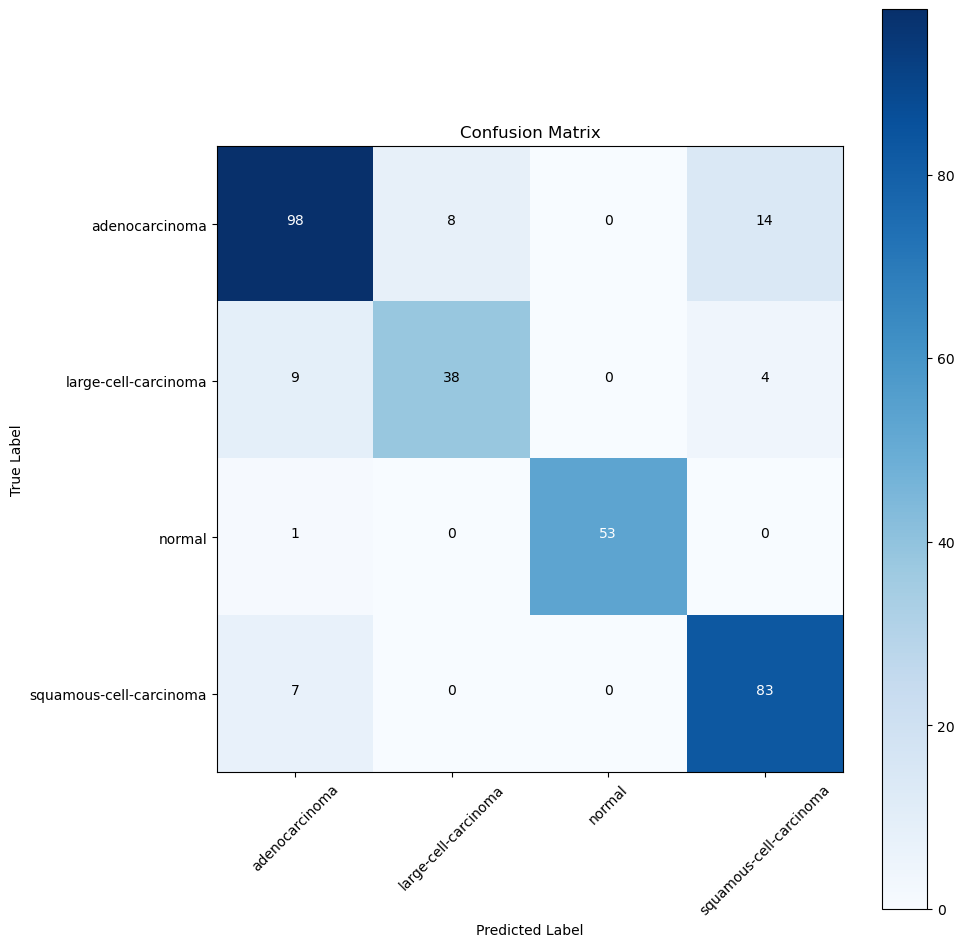

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

target_names = ['adenocarcinoma', 'large-cell-carcinoma', 'normal', 'squamous-cell-carcinoma']
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))